# Representation Learning


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tarfile
import glob
from datetime import datetime
import math
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, silhouette_score, adjusted_rand_score, precision_recall_curve
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [2]:
# Load data
# Training set (Set A)
df_train = pd.read_parquet('final-data/final-set-a.parquet')
df_train = df_train.fillna(0)  # Replace NaN with 0 if any remain

# Validation set (Set B) - for hyperparameter tuning
df_val = pd.read_parquet('final-data/final-set-b.parquet')
df_val = df_val.fillna(0)
if 'ICUType' in df_val.columns:
        print("Removing ICUType column as requested")
        df_val = df_val.drop(columns=['ICUType'])

Removing ICUType column as requested


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196000 entries, 0 to 195999
Data columns (total 42 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         196000 non-null  int64  
 1   Age          196000 non-null  float64
 2   BUN          196000 non-null  float64
 3   Creatinine   196000 non-null  float64
 4   GCS          196000 non-null  float64
 5   Gender       196000 non-null  float64
 6   Glucose      196000 non-null  float64
 7   HCO3         196000 non-null  float64
 8   HCT          196000 non-null  float64
 9   HR           196000 non-null  float64
 10  Height       196000 non-null  float64
 11  K            196000 non-null  float64
 12  Mg           196000 non-null  float64
 13  NIDiasABP    196000 non-null  float64
 14  NIMAP        196000 non-null  float64
 15  NISysABP     196000 non-null  float64
 16  Na           196000 non-null  float64
 17  Platelets    196000 non-null  float64
 18  RecordID     196000 non-

### Q3.1 Pretraining and Linear Probes (4 pts)

We pre-train an autoencoder consisting of the encoder-decoder architecture, and compare with the LSTM approach in question 2.2.

In [4]:
def prepare_sequence_data(df):
    """
    Convert dataframe to sequence format grouped by RecordID.
    Returns a dictionary mapping RecordID to the sequential ICU data.
    """
    patient_sequences = {}
    
    for record_id, group in df.groupby('RecordID'):
        # Sort by timestamp to ensure temporal order
        group = group.sort_values('Time')
        
        # Get features - excluding RecordID and Time
        features = group.drop(['RecordID', 'Time'], axis=1).values
        
        patient_sequences[record_id] = features
    
    return patient_sequences

In [13]:
def create_tensor_dataset(patient_sequences):
    """
    Create a PyTorch TensorDataset from patient sequences.
    Each tensor corresponds to one patient/RecordID sequence.
    """
    sequences = []
    record_ids = []
    
    for record_id, sequence in patient_sequences.items():
        sequences.append(sequence)
        record_ids.append(record_id)

    sequences_tensor = torch.FloatTensor(np.array(sequences))
    record_ids_tensor = torch.LongTensor(np.array(record_ids))
    
    return TensorDataset(sequences_tensor, record_ids_tensor)

In [58]:
# Prepare data 
train_sequences = prepare_sequence_data(df_train)
val_sequences = prepare_sequence_data(df_val)

# Create datasets, dataloaders
train_dataset = create_tensor_dataset(train_sequences)
val_dataset = create_tensor_dataset(val_sequences)

print("\nTrain-Tensor:")
print(f"Dataset length: {len(train_dataset)}")
print(f"First element shape: {train_dataset[0][0].shape}")  # First patient's data shape

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Train-Tensor:
Dataset length: 4000
First element shape: torch.Size([49, 40])


Note that the patient's time series data in the DataLoaders consist of 49 time stamps * 40 features (excluding ICUType, Time, RecordID), so 1960-dimensional data, which we represent in a latent space of lower dimension.

In [59]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )
        self.bn = nn.LayerNorm(hidden_dim * 2)  # *2 for bidirectional
        self.fc = nn.Linear(hidden_dim * 2, embedding_dim)  # *2 for bidirectional
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # average pooling over all time steps
        lstm_out = torch.mean(lstm_out, dim=1)
        lstm_out = self.bn(lstm_out)
        embedding = self.fc(lstm_out)
        
        return embedding

In [60]:
class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.fc_input = nn.Linear(embedding_dim, hidden_dim)
        self.lstm = nn.LSTM(
            hidden_dim,
            hidden_dim, 
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3
        )
        self.bn = nn.LayerNorm(hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, embedding, seq_length):
        #hidden = self.fc(embedding).unsqueeze(0)  # [1, batch_size, hidden_dim]
        #cell = torch.zeros_like(hidden)
        # Repeat the hidden state as input for each time step
        #decoder_input = hidden.permute(1, 0, 2).repeat(1, seq_length, 1)
        #output, _ = self.lstm(decoder_input, (hidden, cell))
        #reconstructed = self.output_layer(output)
        
        initial_hidden = self.fc_input(embedding).unsqueeze(1)  # [batch_size, 1, hidden_dim]
        
        # Repeat for the sequence length
        decoder_input = initial_hidden.repeat(1, seq_length, 1)
        
        # Pass through LSTM, apply layer norm
        lstm_out, _ = self.lstm(decoder_input)
        lstm_out = self.bn(lstm_out)
        
        reconstructed = self.output_layer(lstm_out)
        
        
        return reconstructed

In [61]:
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, num_layers):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, embedding_dim, num_layers)
        self.decoder = Decoder(embedding_dim, hidden_dim, input_dim, num_layers)
    
    def forward(self, x):
        #seq_length = x.size(1)
        # Encoding part
        #embedding = self.encoder(x)
        # Decoding part
        #reconstructed = self.decoder(embedding, seq_length)
        
        seq_length = x.size(1)
        # Encoding part
        embedding = self.encoder(x)
        # Decoding part
        reconstructed = self.decoder(embedding, seq_length)
        
        return reconstructed, embedding

In [62]:
# Verify features dimension
input_dim= train_dataset[0][0].shape[1]  
print("Features dimension train: ", input_dim)

input_dim_val = val_dataset[0][0].shape[1]  
print("Features dimension val: ", input_dim_val)

Features dimension train:  40
Features dimension val:  40


In [30]:
if not os.path.exists("embeddings"):
        os.makedirs("embeddings")

/Users/melanierieff/PycharmProjects/ML4H_project1/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 125/125 [00:26<00:00,  4.78it/s]


Epoch 1/20, Train Loss: 0.404154, Val Loss: 0.796285


100%|██████████| 125/125 [00:28<00:00,  4.40it/s]


Epoch 2/20, Train Loss: 0.327776, Val Loss: 0.800603


100%|██████████| 125/125 [00:27<00:00,  4.62it/s]


Epoch 3/20, Train Loss: 0.313880, Val Loss: 0.802536


100%|██████████| 125/125 [00:29<00:00,  4.26it/s]


Epoch 4/20, Train Loss: 0.298199, Val Loss: 0.801908


100%|██████████| 125/125 [00:27<00:00,  4.59it/s]


Epoch 5/20, Train Loss: 0.290502, Val Loss: 0.809202


100%|██████████| 125/125 [00:28<00:00,  4.38it/s]


Epoch 6/20, Train Loss: 0.272401, Val Loss: 0.792952


100%|██████████| 125/125 [00:28<00:00,  4.44it/s]


Epoch 7/20, Train Loss: 0.260334, Val Loss: 0.801170


100%|██████████| 125/125 [00:26<00:00,  4.75it/s]


Epoch 8/20, Train Loss: 0.257135, Val Loss: 0.797488


100%|██████████| 125/125 [00:28<00:00,  4.35it/s]


Epoch 9/20, Train Loss: 0.254378, Val Loss: 0.802691


100%|██████████| 125/125 [00:27<00:00,  4.61it/s]


Epoch 10/20, Train Loss: 0.252784, Val Loss: 0.806029


100%|██████████| 125/125 [00:38<00:00,  3.29it/s]


Epoch 11/20, Train Loss: 0.244345, Val Loss: 0.801143


100%|██████████| 125/125 [00:28<00:00,  4.45it/s]


Epoch 12/20, Train Loss: 0.240151, Val Loss: 0.807225


100%|██████████| 125/125 [00:27<00:00,  4.57it/s]


Epoch 13/20, Train Loss: 0.238563, Val Loss: 0.802677


100%|██████████| 125/125 [00:27<00:00,  4.56it/s]


Epoch 14/20, Train Loss: 0.237496, Val Loss: 0.805391


100%|██████████| 125/125 [00:26<00:00,  4.73it/s]


Epoch 15/20, Train Loss: 0.233584, Val Loss: 0.803394


100%|██████████| 125/125 [00:27<00:00,  4.62it/s]


Epoch 16/20, Train Loss: 0.231155, Val Loss: 0.805098
Early stopping after 16 epochs


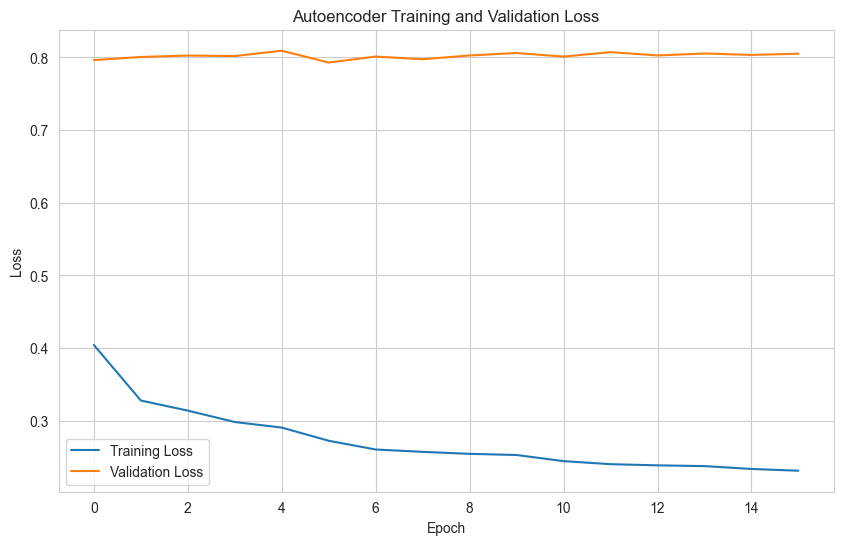

<All keys matched successfully>

In [63]:
# Initialize model and optimization
hidden_dim = 264
embedding_dim = 15
num_layers = 2
autoencoder = TimeSeriesAutoencoder(input_dim, hidden_dim, embedding_dim, num_layers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = autoencoder.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []

# Early stopping parameters
patience = 10
best_val_loss = float('inf')
patience_counter = 0


for epoch in range(num_epochs):
    # Training
    autoencoder.train()
    epoch_loss = 0
    
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        
        # Forward pass
        reconstructed, _ = autoencoder(data)
        loss = criterion(reconstructed, data)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    autoencoder.eval()
    val_loss = 0
    
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            reconstructed, _ = autoencoder(data)
            loss = criterion(reconstructed, data)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    
    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(autoencoder.state_dict(), 'embeddings/best_autoencoder.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            break

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.legend()
plt.savefig('embeddings/autoencoder_loss.png')
plt.show()

# Load the best model
autoencoder.load_state_dict(torch.load('embeddings/best_autoencoder.pth'))

In [64]:
# Function to generate embeddings for all patients
def generate_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    record_ids = []
    
    with torch.no_grad():
        for data, ids in dataloader:
            data = data.to(device)
            _, embedding = model(data)
            
            embeddings.append(embedding.cpu().numpy())
            record_ids.extend(ids.numpy())
    
    # Concatenate all embeddings
    embeddings = np.vstack(embeddings)
    
    # Create a dictionary mapping record_id to embedding
    embedding_dict = {record_id: emb for record_id, emb in zip(record_ids, embeddings)}
    
    return embedding_dict

# Generate embeddings, save them
train_embedding_dict = generate_embeddings(autoencoder, train_loader, device)
val_embedding_dict = generate_embeddings(autoencoder, val_loader, device)

embedding_df_train = pd.DataFrame.from_dict(train_embedding_dict, orient='index')
embedding_df_train.index.name = 'RecordID'
embedding_df_train.to_csv('embeddings/train_embeddings.csv')

embedding_df_val = pd.DataFrame.from_dict(val_embedding_dict, orient='index')
embedding_df_val.index.name = 'RecordID'
embedding_df_val.to_csv('embeddings/val_embeddings.csv')

### Linear Probe evaluation

In [65]:
# Load outcomes data, extract the in-hospital mortality labels
outcomes_train = pd.read_parquet('processed-data/processed-outcomes-a.parquet')  
outcomes_val = pd.read_parquet('processed-data/processed-outcomes-b.parquet')    
outcomes_test = pd.read_parquet('processed-data/processed-outcomes-c.parquet')  
train_labels = outcomes_train.set_index('RecordID')['In-hospital_death']
val_labels = outcomes_val.set_index('RecordID')['In-hospital_death']
test_labels = outcomes_test.set_index('RecordID')['In-hospital_death']

# Prepare data for linear probe, merge embeddings with labels
train_data = embedding_df_train.join(train_labels, how='inner')
val_data = embedding_df_val.join(val_labels, how='inner')

# Split features and labels
X_train = train_data.drop('In-hospital_death', axis=1)
y_train = train_data['In-hospital_death']

X_val = val_data.drop('In-hospital_death', axis=1)
y_val = val_data['In-hospital_death']

C=0.001, Validation AuROC: 0.4922, Validation AuPRC: 0.1421
C=0.01, Validation AuROC: 0.5081, Validation AuPRC: 0.1498
C=0.1, Validation AuROC: 0.5130, Validation AuPRC: 0.1525
C=1, Validation AuROC: 0.5137, Validation AuPRC: 0.1530
C=10, Validation AuROC: 0.5137, Validation AuPRC: 0.1531
C=100, Validation AuROC: 0.5137, Validation AuPRC: 0.1531
Best validation AuROC: 0.5137
Removing ICUType column as requested
Test AuROC: 0.4714
Test AuPRC: 0.1553


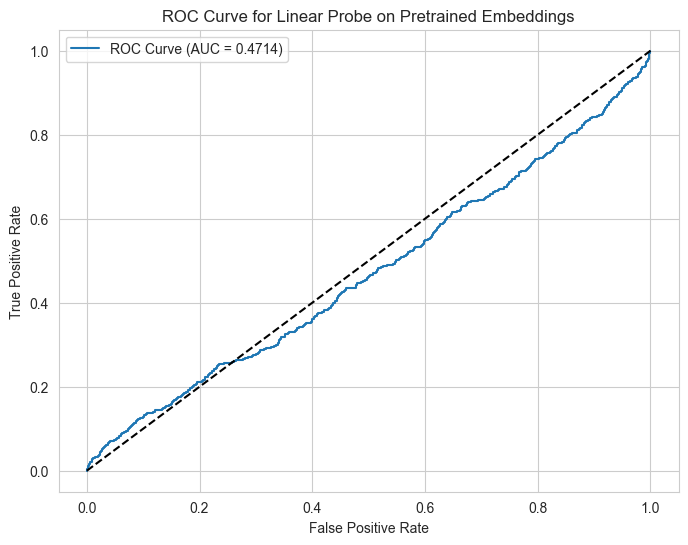

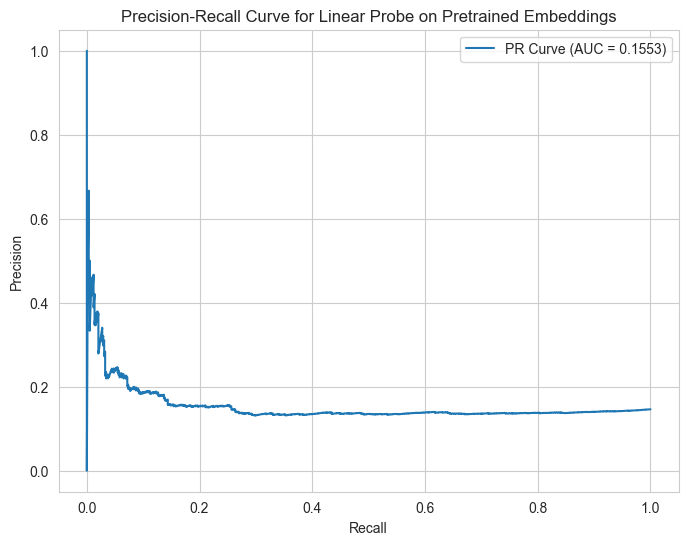

In [68]:
# Logistic Regression, try different regularization strengths
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
best_val_auc = 0
best_model = None

for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    val_probs = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_probs)
    val_auprc = average_precision_score(y_val, val_probs)
    
    print(f"C={C}, Validation AuROC: {val_auc:.4f}, Validation AuPRC: {val_auprc:.4f}")
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = model

print(f"Best validation AuROC: {best_val_auc:.4f}")

# Evaluation on test set
df_test = pd.read_parquet('final-data/final-set-c.parquet')
df_test = df_test.fillna(0)
if 'ICUType' in df_test.columns:
        print("Removing ICUType column as requested")
        df_test = df_test.drop(columns=['ICUType'])

# Prepare test data
test_sequences = prepare_sequence_data(df_test)
test_dataset = create_tensor_dataset(test_sequences)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Generate embeddings for test set
test_embedding_dict = generate_embeddings(autoencoder, test_loader, device)
embedding_df_test = pd.DataFrame.from_dict(test_embedding_dict, orient='index')
embedding_df_test.index.name = 'RecordID'

# Merge with labels
test_data = embedding_df_test.join(test_labels, how='inner')
X_test = test_data.drop('In-hospital_death', axis=1)
y_test = test_data['In-hospital_death']

# Make predictions
test_probs = best_model.predict_proba(X_test)[:, 1]


test_auc = roc_auc_score(y_test, test_probs)
test_auprc = average_precision_score(y_test, test_probs)

print(f"Test AuROC: {test_auc:.4f}")
print(f"Test AuPRC: {test_auprc:.4f}")


fpr, tpr, _ = roc_curve(y_test, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Linear Probe on Pretrained Embeddings')
plt.legend()
plt.savefig('embeddings/roc_curve.png')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {test_auprc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Linear Probe on Pretrained Embeddings')
plt.legend()
plt.savefig('embeddings/pr_curve.png')
plt.show()

### Q3.2 Simulate label scarcity (4 pts)

### Q3.2 Part i)

We train three different supervised models with the same (or as similar as possible) architecture as our pretrained network, but only use 100, 500, and 1000 patients from the training set and report our full test set performance (2 pts).

### Q3.2 Part ii)

We train three linear probes (as in Q3.1 step 2) using only 100, 500, 1000 labelled patients and report the full test set C performance (2 pts).

In [75]:
# Assuming we have
# - embedding_df_train: DataFrame with embeddings for training set (from set A)
# - train_labels: Series with labels for training set (from set A)
# - X_test, y_test: Test data embeddings and labels (from set C)

def train_linear_probe_sparse(X_train, y_train, X_test, y_test, n_samples):
    """
    Train a logistic regression model using only n_samples labeled examples
    """
    
    # Randomly sample n patients, we use stratified sampling to maintain class imbalance
    _, X_sampled, _, y_sampled = train_test_split(
        X_train, y_train, 
        test_size=n_samples/len(y_train),
        stratify=y_train,
        random_state=42
    )
        
    print(f"Training with {len(y_sampled)} samples")
    print(f"Class distribution: {y_sampled.value_counts().to_dict()}")
    
    # Train logistic regression
    model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)
    model.fit(X_sampled, y_sampled)
    
    # Evaluate on test set
    test_probs = model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, test_probs)
    test_auprc = average_precision_score(y_test, test_probs)
    
    return model, test_auc, test_auprc


Training with 100 labeled samples:
Training with 100 samples
Class distribution: {0: 86, 1: 14}
Test AuROC: 0.5021
Test AuPRC: 0.1713

Training with 500 labeled samples:
Training with 500 samples
Class distribution: {0: 431, 1: 69}
Test AuROC: 0.5290
Test AuPRC: 0.1939

Training with 1000 labeled samples:
Training with 1000 samples
Class distribution: {0: 862, 1: 138}
Test AuROC: 0.4655
Test AuPRC: 0.1500

Results summary:
   n_samples     AuROC     AuPRC
0        100  0.502084  0.171314
1        500  0.529003  0.193912
2       1000  0.465547  0.149955


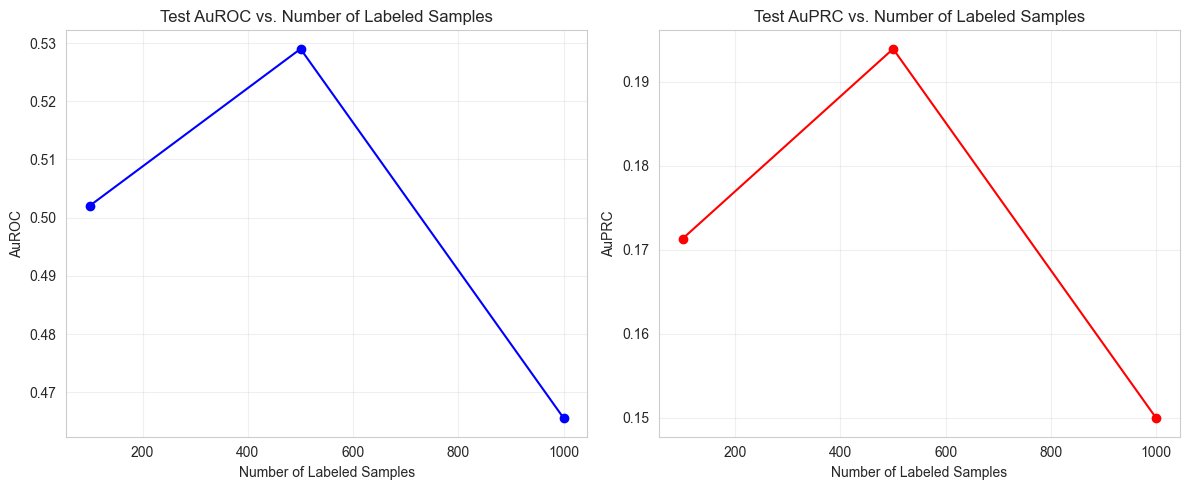

In [76]:
train_data = embedding_df_train.join(train_labels, how='inner')
X_train = train_data.drop('In-hospital_death', axis=1)
y_train = train_data['In-hospital_death']

# Sample sizes to evaluate
sample_sizes = [100, 500, 1000]
results = []

# Train and evaluate for each sample size
for n in sample_sizes:
    print(f"\nTraining with {n} labeled samples:")
    _, auc, auprc = train_linear_probe_sparse(X_train, y_train, X_test, y_test, n)
    
    print(f"Test AuROC: {auc:.4f}")
    print(f"Test AuPRC: {auprc:.4f}")
    
    results.append({
        'n_samples': n,
        'AuROC': auc,
        'AuPRC': auprc
    })
results_df = pd.DataFrame(results)
print("\nResults summary:")
print(results_df)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results_df['n_samples'], results_df['AuROC'], 'o-', color='blue')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('AuROC')
plt.title('Test AuROC vs. Number of Labeled Samples')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(results_df['n_samples'], results_df['AuPRC'], 'o-', color='red')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('AuPRC')
plt.title('Test AuPRC vs. Number of Labeled Samples')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('embeddings/limited_labels_performance.png', dpi=300)
plt.show()

### Q3.3: Visualising Learned Representations (4 Pts)

We visualize the patient representations of the representation / latent space in two dimensions using t-SNE. 

In [69]:
#Generate embeddings for test set
test_embedding_dict = generate_embeddings(autoencoder, test_loader, device)
embedding_df_test = pd.DataFrame.from_dict(test_embedding_dict, orient='index')
embedding_df_test.index.name = 'RecordID'
embedding_df_test.to_csv('embeddings/test_embeddings.csv')

test_data = embedding_df_test.join(test_labels, how='inner')
X_test = test_data.drop('In-hospital_death', axis=1)
y_test = test_data['In-hospital_death']

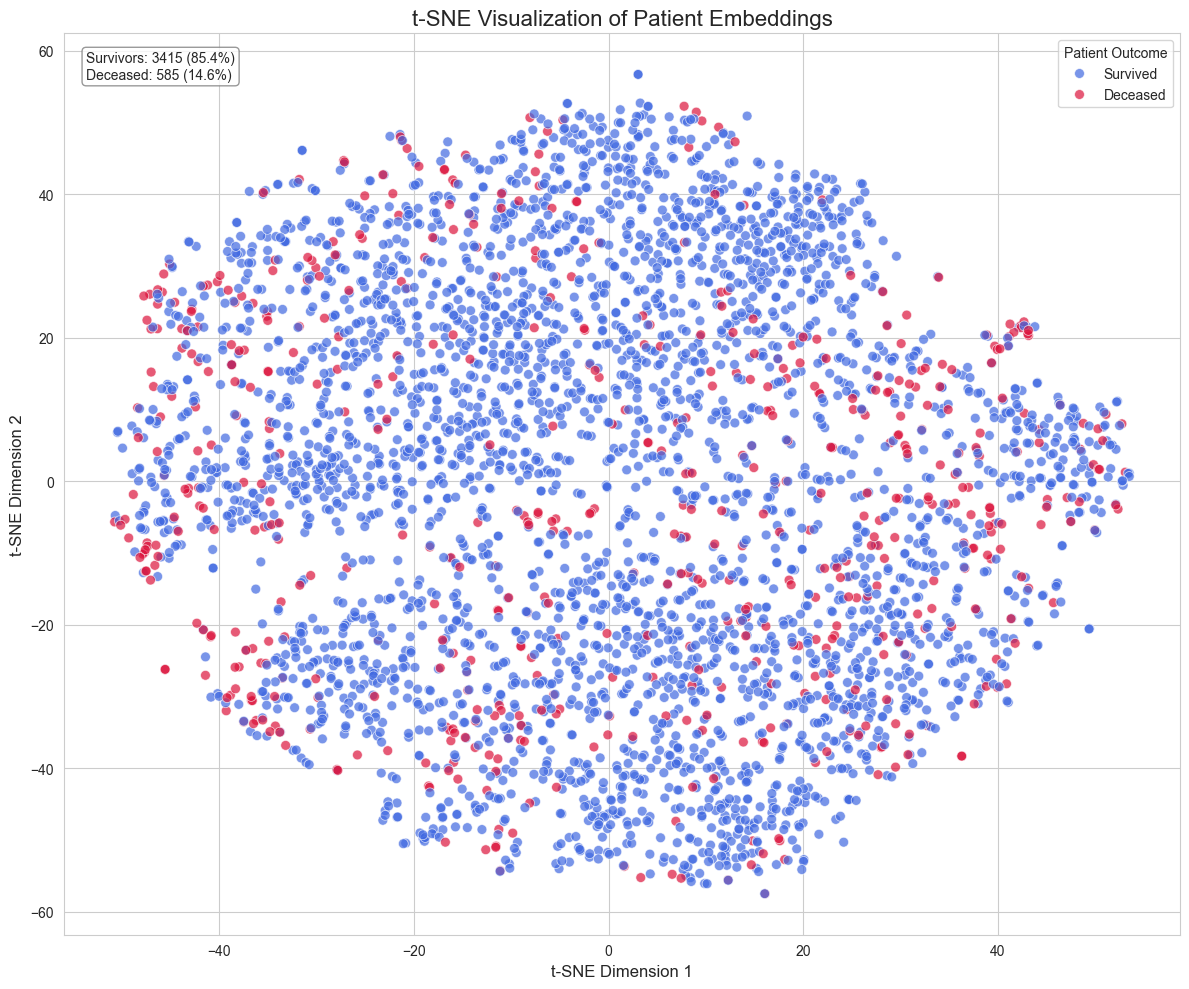

In [70]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_test.values)
tsne_df = pd.DataFrame({
    'x': X_tsne[:, 0],
    'y': X_tsne[:, 1],
    'label': y_test.values
})

tsne_df['label'] = tsne_df['label'].astype('category')

# different colors for labels 0 or 1
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    x='x', y='y',
    hue='label',
    palette={0: 'royalblue', 1: 'crimson'},
    data=tsne_df,
    alpha=0.7,
    s=50,
)

handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Survived', 'Deceased'], title='Patient Outcome')
plt.title('t-SNE Visualization of Patient Embeddings', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

survivors = (y_test == 0).sum()
deceased = (y_test == 1).sum()
total = len(y_test)

plt.annotate(f'Survivors: {survivors} ({survivors/total:.1%})\nDeceased: {deceased} ({deceased/total:.1%})',
             xy=(0.02, 0.98), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
             ha='left', va='top', fontsize=10)

plt.tight_layout()
plt.savefig('tsne_visualization.png', dpi=300)
plt.show()

Now, we answer the question whether data points are distributed differently for different labels.

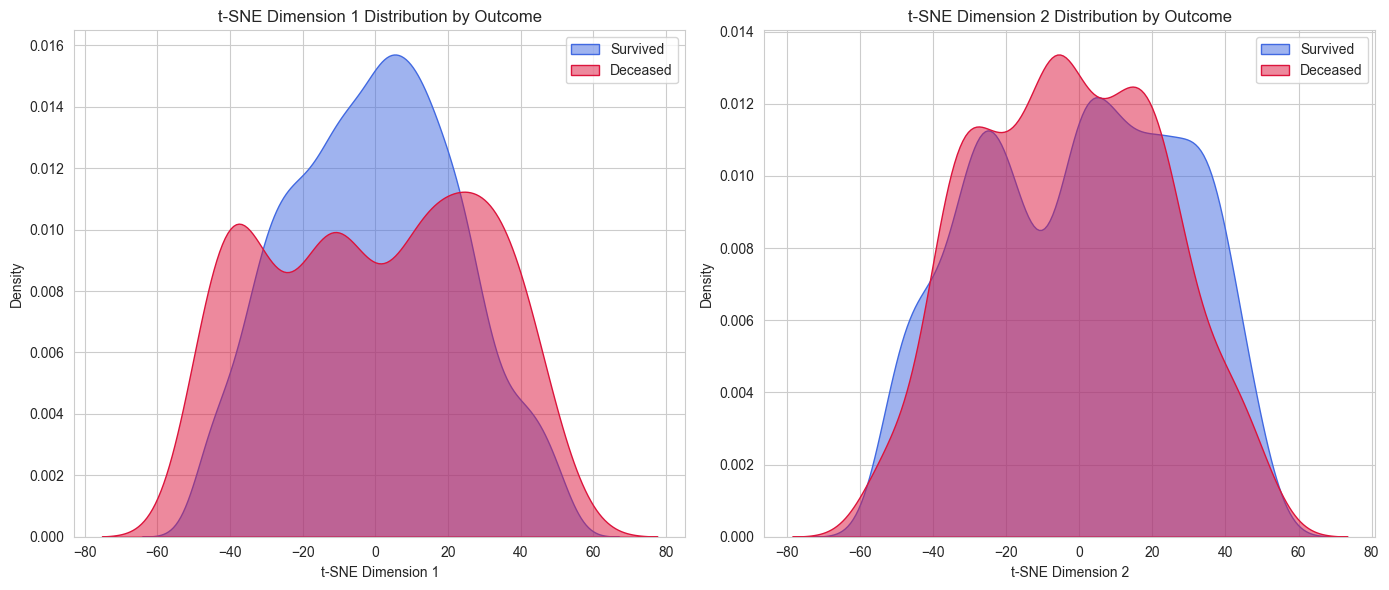

In [71]:
# Create a separate visualization with density plots for each class, two subplots for dimension 1 and 2
plt.figure(figsize=(14, 6))
for i, dim in enumerate(['x', 'y']):
    plt.subplot(1, 2, i+1)
    for label, color in zip([0, 1], ['royalblue', 'crimson']):
        subset = tsne_df[tsne_df['label'] == label]
        sns.kdeplot(subset[dim], fill=True, color=color, alpha=0.5, 
                   label='Survived' if label == 0 else 'Deceased')
    
    plt.title(f't-SNE Dimension {i+1} Distribution by Outcome')
    plt.xlabel(f't-SNE Dimension {i+1}')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.savefig('tsne_density_by_class.png', dpi=300)
plt.show()

Next, we use a quantitative clustering metric, k-means clustering, to assess the quality of your dimensionality reduction w.r.t. target class labels. 

K=2: Silhouette Score = 0.2106, Adjusted Rand Index = 0.0510


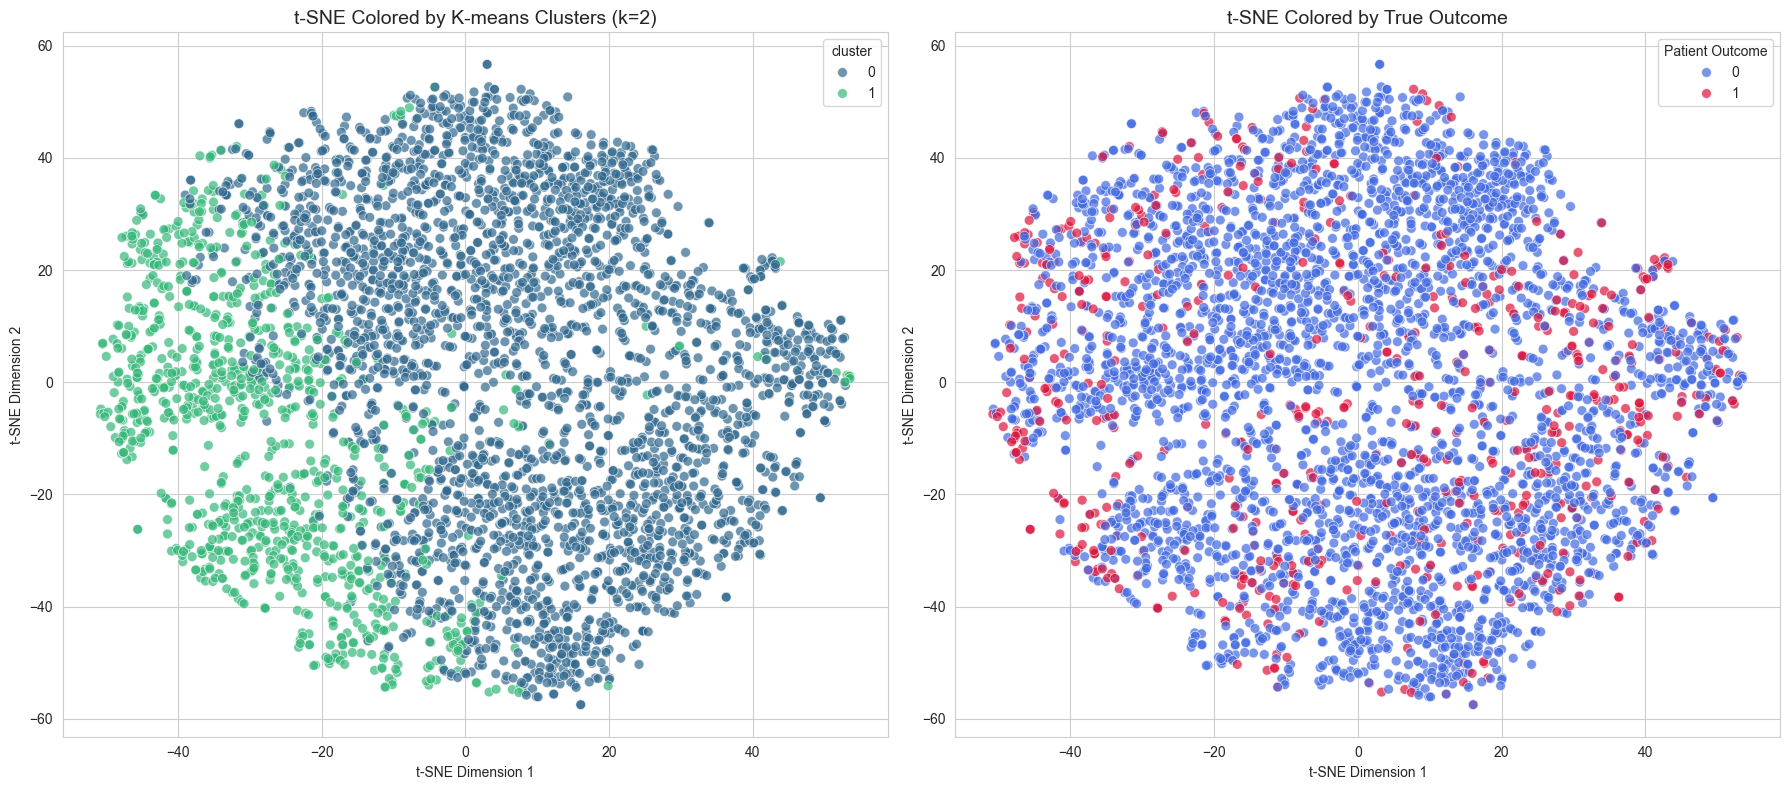

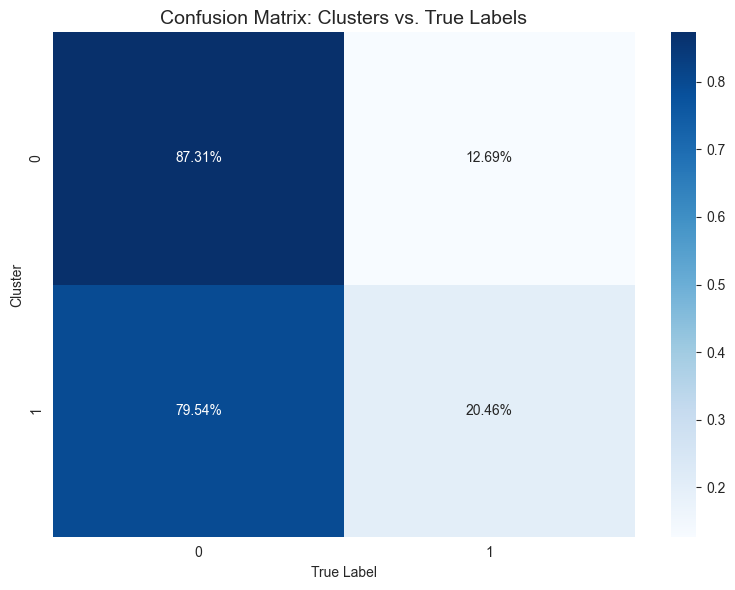

K=3: Silhouette Score = 0.1110, Adjusted Rand Index = 0.0239
K=4: Silhouette Score = 0.1055, Adjusted Rand Index = 0.0243
K=5: Silhouette Score = 0.1013, Adjusted Rand Index = 0.0355


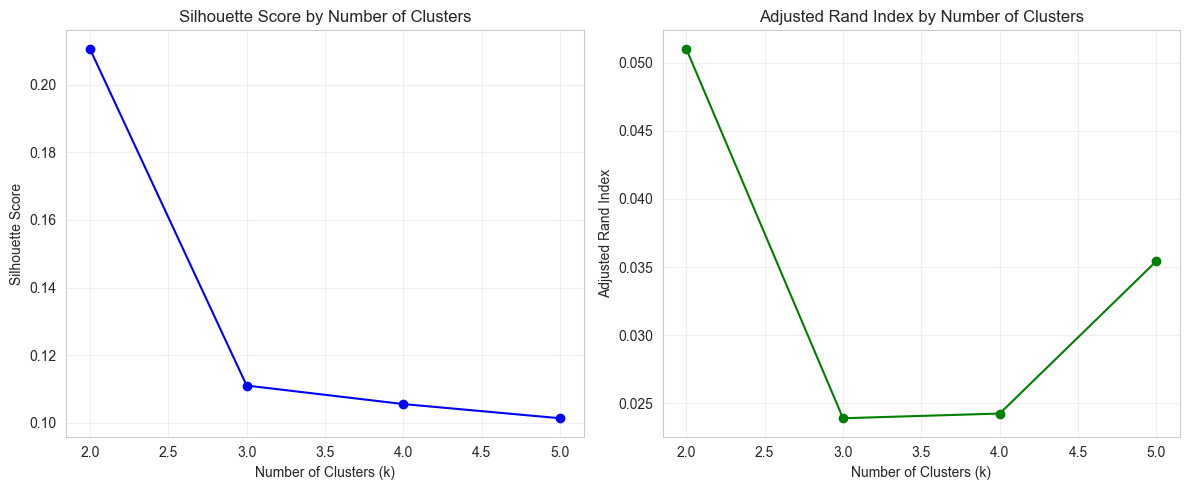

In [74]:
# Try different numbers of clusters
k_values = [2, 3, 4, 5]
silhouette_scores = []
rand_scores = []

for k in k_values:
    # Fit K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_test.values)
    
    # Calculate silhouette score & adjusted Rand index (to compare clusters with true labels)
    sil_score = silhouette_score(X_test.values, clusters)
    silhouette_scores.append(sil_score)
    rand_score = adjusted_rand_score(y_test.values, clusters)
    rand_scores.append(rand_score)
    print(f"K={k}: Silhouette Score = {sil_score:.4f}, Adjusted Rand Index = {rand_score:.4f}")
    
    # For k=2, visualize cluster assignments vs true labels
    if k == 2:
        # Add cluster assignments to our dataframe
        tsne_df['cluster'] = clusters
        
        plt.figure(figsize=(18, 8))# First plot: Color by cluster
        plt.subplot(1, 2, 1)
        sns.scatterplot(x='x', y='y', hue='cluster', data=tsne_df, palette='viridis', alpha=0.7, s=50)
        plt.title('t-SNE Colored by K-means Clusters (k=2)', fontsize=14)
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')

        plt.subplot(1, 2, 2) # Second plot: Color by true label
        sns.scatterplot(x='x', y='y', hue='label', data=tsne_df, 
                       palette={0: 'royalblue', 1: 'crimson'}, alpha=0.7, s=50)
        plt.title('t-SNE Colored by True Outcome', fontsize=14)
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.legend(title='Patient Outcome')
        
        plt.tight_layout()
        plt.savefig('tsne_clusters_vs_labels.png', dpi=300)
        plt.show()
        cluster_label_df = pd.DataFrame({
            'cluster': clusters,
            'label': y_test.values
        })
        
        # Assuming cluster 0 maps to label 0 and cluster 1 to label 1
        # If not, we may need to flip the mapping
        confusion = pd.crosstab(
            cluster_label_df['cluster'], 
            cluster_label_df['label'],
            rownames=['Cluster'],
            colnames=['True Label'],
            normalize='index'  # Normalize by row for better interpretation
        )
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion, annot=True, cmap='Blues', fmt='.2%', cbar=True)
        plt.title('Confusion Matrix: Clusters vs. True Labels', fontsize=14)
        plt.tight_layout()
        plt.savefig('cluster_label_confusion.png', dpi=300)
        plt.show()
        
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, 'o-', color='blue')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score by Number of Clusters')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_values, rand_scores, 'o-', color='green')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Adjusted Rand Index')
plt.title('Adjusted Rand Index by Number of Clusters')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('clustering_metrics.png', dpi=300)
plt.show()